# Image Preparation 

Based on a blog post from 2011, by hobbyist Michael Hamilton, we have a PunchCard Python class that already works to read card images that are arranged with 
their "dog ear" corner on the upper left and with punched holes being lighter than the card itself, i.e. backlit cards. After some minor adjustments for recent versions of Python, Hamilton's class can find the edges of a card within the image and read the data encoded by the holes.

Our goal is to extend this same functionality to more images of punched cards:
* Support front-lit cards (where holes are darker than the card)
* Support the reverse-side scans prevalent in the NARA sample images. 
* Support rotation and flip of card images to normalize their orientation.

In short, our goal is to support reading of punchcard images, no matter how they are photographed. So long as the card is centered in the image and aligned either vertically or horizontally. For this to work, we need to perform a number of image analysis and transformation steps.

## Backlighting the Cards (Inversion)

Some cards may be photographed on backgrounds that are darker than the card itself, making the punches or holes appear darker than the card. Our data reading script is based on backlit cards, with holes showing lighter than the card itself. So we have to detect this situation and then correct for it.

We came up with a relatively simple formula for testing whether an image is backlit or not. We simply divide the image up into center and edge regions and then see if the center is darker or lighter on average, than the edge. In the code below, we divided the image into the center region and the region just left of center.

In [1]:
from PIL import ImageStat
def brightness( im ):
    stat = ImageStat.Stat(im)
    return stat.mean[0]

# Determine if card surface is darker than the background
def isbacklit(image):
    # is the center lighter or darker than the edges..
    # pick a center square and avg brightness
    width, height = image.size
    ctr_box = (width/4, height/4, (width/4)*3, (height/4)*3)
    ctr_region = image.crop(ctr_box)
    display(ctr_region)
    # pick square left edge to center square and avg brightness.
    left_box = (0, height/4, width/4, (height/4)*3)
    left_region = image.crop(left_box)
    display(left_region)
    left_brightness = brightness(left_region)
    center_brightness = brightness(ctr_region)
    return left_brightness > center_brightness

Now we can run this code on our sample image, first reusing the image loading code from the last notebook. 

Our next step is to convert the "mode" of the image to grayscale, since we only care about light and dark. "L" mode in PIL means grayscale with 8-bits per pixel. That means that each pixel in our image will be in the range of 0 (pitch black) to 255 (white). (binary values from '00000000' to '11111111') Using grayscale makes image math easier, as each pixel is represented by a single brightness value, instead of three separate values from red, green, and blue.
After converting to grayscale, we pass the new image to the isbacklit() function. Note that we also call display() in the code above so that you can see the two regions that are being compared.

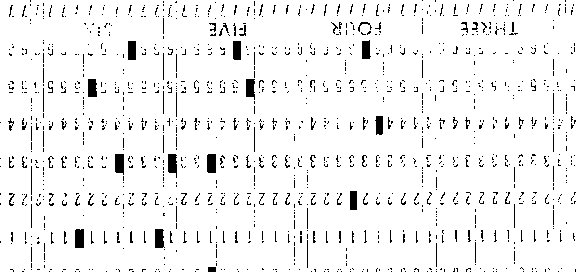

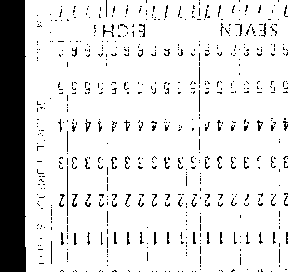

backlit: False


In [2]:
# Loading the Data
from PIL import Image

# Read the image file into an Image object:
image = Image.open("cards/C04D01L-1.png")
image2 = image.convert(mode="L")
backlit = isbacklit(image2)
print("backlit: {}".format(backlit))

So, we have learned that our card is not backlit, i.e. the holes are darker than the card itself. In order to use this image, we first have to reverse the white and black regions. It turns out that reversing an image is straightforward.

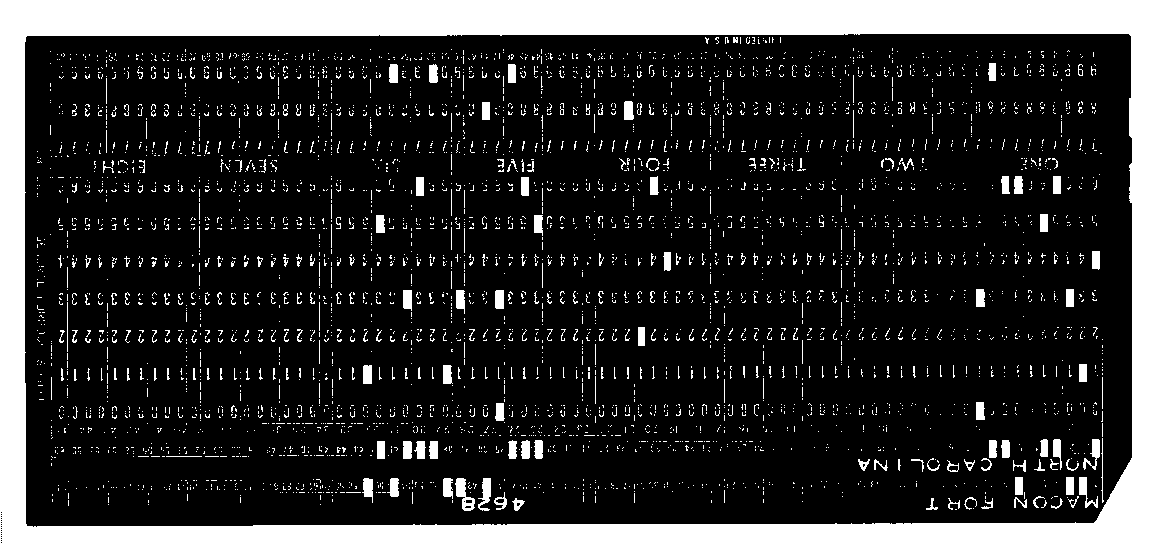

In [3]:
from PIL import ImageOps
if backlit:
    image3 = image2
else:
    image3 = ImageOps.invert(image2)
display(image3)

Look at that! We have normalized our image so that will all show a dark card with lighter holes.

## Cropping the Image to the Card

We are going to need to focus on the geometry of the card itself, in order to detect and place the "dog ear" on the upper-left corner. So we need to cut away the portions of the image that surround the card. Now that we have a backlit card, these edge regions are white. Another way of saying this is that those edge pixels have higher numerical values, approaching 255. Our next task is to find the left, right, top, and bottom edges, where the white pixels stop and the card begins.

We are going to use math to do this, based on the color values stored for each pixel. Using an *array* of image pixel values, we are going to sum up those values along the vertical axis. This gives a list or *vector* of total brightness from left to right in the image.

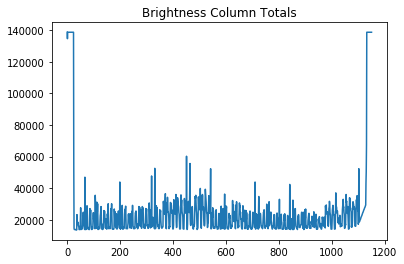

In [4]:
# We are going to show our work using MatPlotLib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy

pix = numpy.array(image3)
brightness_totals = numpy.sum(pix, axis=0)  # 0 is the vertical axis

# showing the vector
n = range(0, len(brightness_totals)-1)
plt.plot(n, brightness_totals[n])
plt.title('Brightness Column Totals');



This graph shows very high brightness on the edges and then minimal brightness on the card itself.
In order to find the edge of the card, we need to decide when the brightness drops off. To review so far, we have created a list of
brightness values that correspond to each pixel column in the image, going from left to right. You can see that this method would not
work if we had not normalized our image to a backlit card.

Now let's figure out where in that list the brightness value drops below a certain threshold (left card edge) and where it returns above that threshold (right card edge). To do that we can loop through the list from each end and save the positions of those transitions.

In [5]:
max = pix.shape[0]*255  # calculate the maximum possible column value (all white pixels)
print("Max pixel column value: {}".format(max))
threshold = int(max*.8)  # Set a threshold as a fraction of the maximum value.
print("Threshold column value: {}".format(threshold))
first = 0  # If we do not cross the threshold, then card is at the edge already, i.e. column 0 is a card pixel.
for i in range(0, len(brightness_totals)-1):
    if(brightness_totals[i] < threshold):
        first = i-1
        break
last = len(brightness_totals)-1  # Last pixel is a card pixel, if we never detect the transition from the right edge.
for i in range(0, len(brightness_totals)-1):
    if(brightness_totals[len(brightness_totals)-1-i] < threshold):
        last = len(brightness_totals)-i
        break
print("first: {}, last: {}".format(first, last))

Max pixel column value: 138720
Threshold column value: 110976
first: 24, last: 1132


We have just calculated the horizontal offsets of the card within the image. The left edge of the card starts at column 24 and the right edge ends at column 1132.
With a little work, we can make this code into a function that will work for both vertical and horizontal dimensions..

In [6]:
def findMargins(im, axis=0, threshold_ratio=.8):
    pix = numpy.array(im)
    max = pix.shape[axis]*255
    threshold = int(max*threshold_ratio)
    brightness_totals = numpy.sum(pix, axis=axis)
    first = 0
    last = len(brightness_totals)-1
    for i in range(0, len(brightness_totals)-1):
        if(brightness_totals[i] < threshold):
            first = i-1
            break
    for i in range(0, len(brightness_totals)-1):
        if(brightness_totals[len(brightness_totals)-1-i] < threshold):
            last = len(brightness_totals)-i
            break
    return (first, last)

In [7]:
(left, right) = findMargins(image3, axis=0)
print("left: {}, right: {}".format(left, right))

left: 24, right: 1132


A quick test run shows that the same values are returned for the horizontal offsets (axis=0). Now let's find the vertical offsets.

In [8]:
(top, bottom) = findMargins(image3, axis=1)
print("top: {}, bottom: {}".format(top, bottom))

top: 33, bottom: 525


Now we have enough information to crop the image to just include the card without background. This may be a little hard to see on the white background of the notebook page..

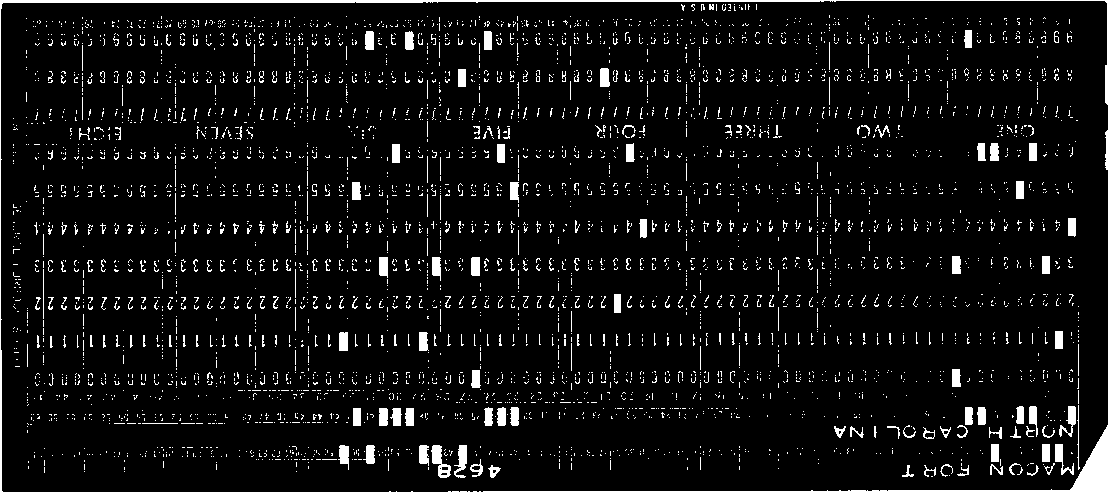

In [9]:
crop_box = (left, top, right, bottom)
image4 = image3.crop(crop_box)
display(image4)

## Rotate Card Image to "Landscape" Orientation

Our card reading script expects card images where the width is longer than the height. Some images may be oriented the other way, in "portrait" orientation. We have to rotate any portrait oriented cards by one quarter turn, or 90 degrees. We can do this with a call to a standard library function for image transformations.

In [10]:
landscape_image = image4
if(image4.size[1] > image4.size[0]): 
    print('rotating card')
    landscape_image = image4.transpose(Image.ROTATE_90) 

No rotation operation is performed because our example is already in landscape orientation.

## Detect the Punchcard

With a cropped card and a known orientation, we have enough data to determine whether or not this is an image of a punchcard or not. A standard IBM 029 punchcard measures 7 3/8 inches long and 3 ¼ inches tall. If we allow for some slight variation, then we can write a test to see if our card’s proportions are the same. We’ll create two height to width proportions, one slightly higher than standard and one slightly lower. Then we can see if the image proportions lie between those two numbers. 

In [11]:
CARD_WIDTH = 7.0 + 3.0/8.0  # inches
CARD_HEIGHT = 3.25  # inches
CARD_SPEC_TOLERANCE = .15  # inches, adjust as needed 
CARD_W_TO_H_RATIO_HIGH = (CARD_WIDTH + CARD_SPEC_TOLERANCE) / CARD_HEIGHT 
CARD_W_TO_H_RATIO_LOW = (CARD_WIDTH - CARD_SPEC_TOLERANCE) / CARD_HEIGHT 
card_ratio = float(landscape_image.size[0]) / float(landscape_image.size[1]) 
is_card = card_ratio <= CARD_W_TO_H_RATIO_HIGH and card_ratio > CARD_W_TO_H_RATIO_LOW
print('punchcard: {}'.format(is_card))

punchcard: True


# Flip the "Dog Ear" to Top-Left Corner

Michael Hamilton’s code expects the “dog ear” or angle cut-out in the card to be positioned in the top-left of the image. That is where the dog ear is normally positioned when you look at the front of a paper punch card. However, we want our code to work even when the card was photographed from the back, as is the case with our NARA samples. There are two kinds of image flipping operations we can do, left-right and top-bottom, but we may need to perform both if the dog ear is in the bottom-right, or neither if the “dog ear” is already in the top-left. Since the dog ear reveals more of the white background, the dog ear corner will have a higher average brightness than the other corners. We can use this fact to choose the right combination of flip operations. In our code we perform each possible combination of flip operations, measuring the brightness of the top-left corner. Then we choose the flip combination for which that corner was brightest. Python has some useful functions that help us iterate through all the combinations of two choices. 

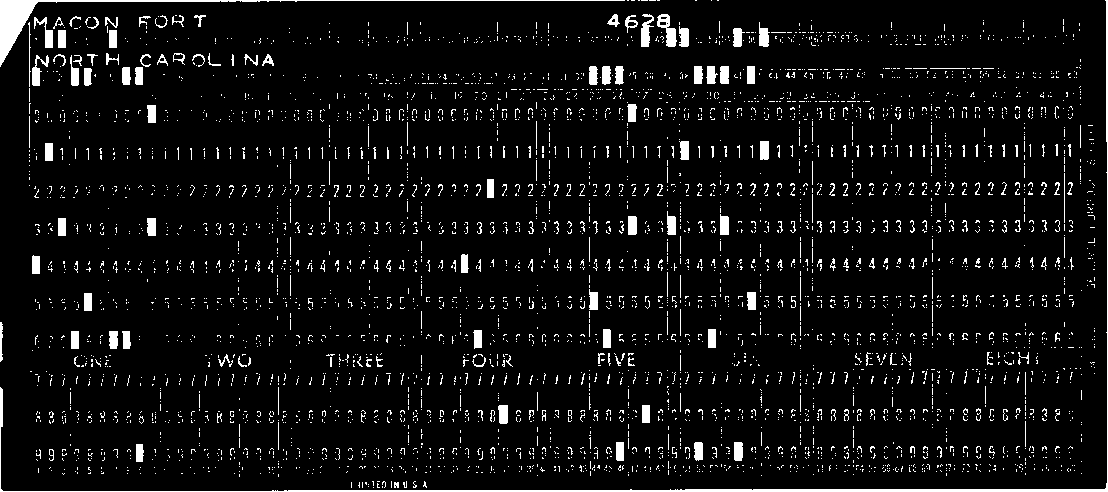

In [12]:
testbox = (0,0,20,20)  # top-left corner
brightest = -1
flipped_image = None

for (lr,tb), value in numpy.ndenumerate(numpy.zeros((2,2))): 
    test_image = landscape_image
    if lr: 
        test_image = test_image.transpose(Image.FLIP_LEFT_RIGHT) 
    if tb: 
        test_image = test_image.transpose(Image.FLIP_TOP_BOTTOM) 
    b = brightness(test_image.crop(testbox)) 
    if b > brightest: 
        brightest = b 
        flipped_image = test_image
display(flipped_image)

This code performs every combination of left-right and top-bottom flips, by denumerating the positions in a 2-by-2 array, starting with (0, 0) representing no flip operations, and ending with (1,1) representing both left-right and top-bottom flips. Whichever combination produces the brightest square in the top-left corner is the solution, i.e. the best flip combination.

Lastly, we are going to save the resulting image, but add a small margin all the way around. That margin will allow Hamilton's code to once again detect the edges of the card.

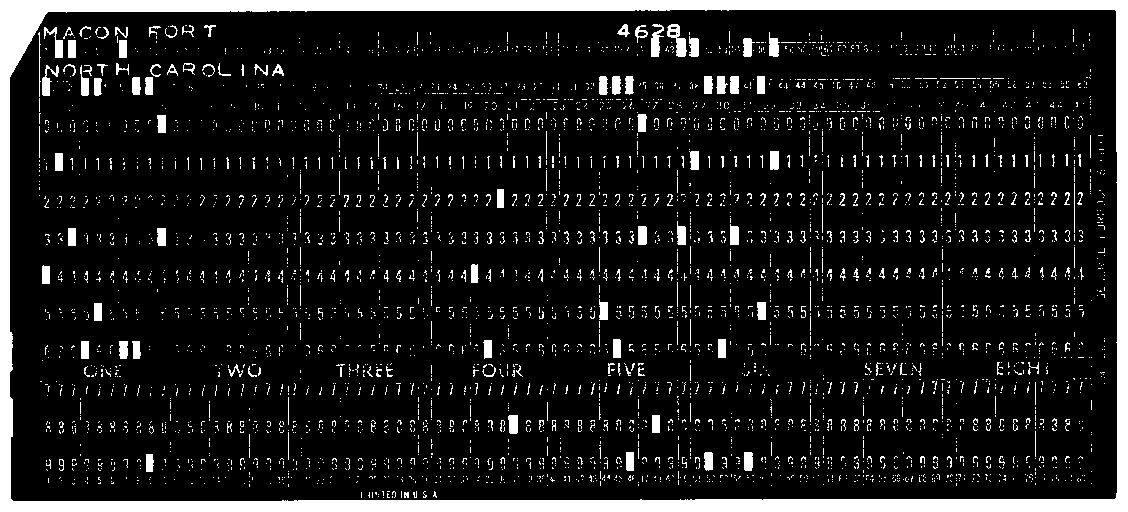

In [13]:
border_image = ImageOps.expand(flipped_image,border=10,fill='white')
display(border_image)
border_image.save('prepared_image.png')

# Review

This notebook encompassed many steps that are needed to impose some common traits on punchcard images, making them readable by Michael Hamilton's code. Any punchcard image that is processed through these steps will be backlit and layed out like the "Macon Fort" card displayed by the code above. We used a number of standard image library calls to make changes to the images. We made these changes in response to mathematical measurements and calculations that were performed on pixel color values. Now this image is ready for reading by our adaption of Michael Hamilton's code.

# My Image Preparation Notes
(This area provided for students to record their notes on the dataset.)

Next: [Data Extraction](notebook-3.ipynb)